In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [2]:
data = pd.read_csv("../../data/datos_leb.csv")

In [3]:
def parse_embedding(x):
    return np.array(json.loads(x)) if isinstance(x, str) else np.array(x)

data['embedding'] = data['embedding'].apply(parse_embedding)

In [4]:
X = np.vstack(data['embedding'].values)


In [5]:
K = range(2, 19)

inertia_list = []
sil_list = []

for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X)
    inertia_list.append(km.inertia_)
    sil_list.append(silhouette_score(X, labels))


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


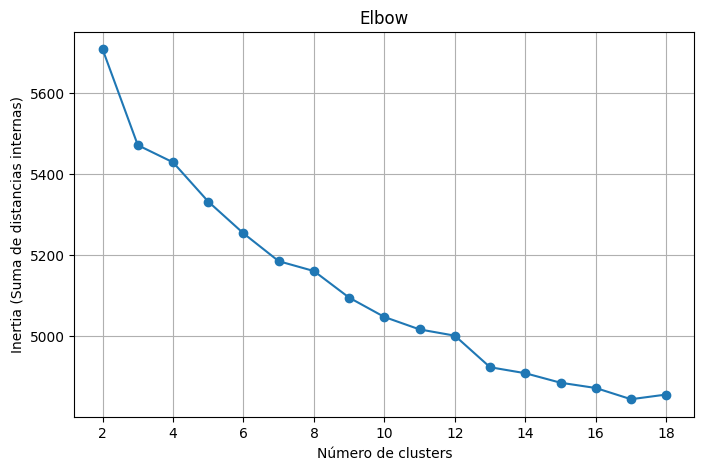

In [6]:
plt.figure(figsize=(8,5))
plt.plot(K, inertia_list, marker='o')
plt.title("Elbow")
plt.xlabel("Número de clusters")
plt.ylabel("Inertia (Suma de distancias internas)")
plt.grid(True)
plt.show()


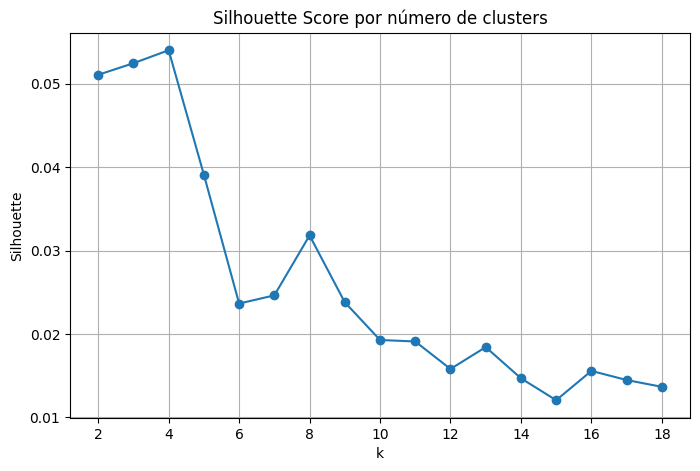

In [7]:
plt.figure(figsize=(8,5))
plt.plot(K, sil_list, marker='o')
plt.title("Silhouette Score por número de clusters")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


In [8]:
best_k = K[np.argmax(sil_list)]
best_k


4

In [17]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

data['cluster'] = labels


In [18]:
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

nltk.download("stopwords")

stop_en = set(stopwords.words("english"))
stop_es = set(stopwords.words("spanish"))
stop = stop_en | stop_es

custom_stop = {
    "the","and","of","to","in","is","it","i","was","for","my","we","you","me",
    "they","our","very","really","one","great","good","nice","amazing"
}

stop |= custom_stop


[nltk_data] Downloading package stopwords to /home/bita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúñ ]", " ", text)
    tokens = [w for w in text.split() if w not in stop and len(w) > 2]
    return tokens

data["tokens"] = data["text"].apply(preprocess)


In [20]:
from math import log

cluster_docs = {c: [] for c in data.cluster.unique()}

for c, tokens in data.groupby("cluster")["tokens"]:
    cluster_docs[c] = [t for doc in tokens for t in doc]

# Document Frequency: en cuántos clusters aparece cada palabra
all_words = set(word for c in cluster_docs for word in cluster_docs[c])
df = {word: sum(word in cluster_docs[c] for c in cluster_docs) for word in all_words}

representative_words = {}

for c in cluster_docs:
    word_counts = Counter(cluster_docs[c])
    total_words = len(cluster_docs[c])

    tfidf = {}
    for word, tf in word_counts.items():
        tf = tf / total_words
        idf = log((1 + len(cluster_docs)) / (1 + df[word])) + 1
        tfidf[word] = tf * idf

    # Top 10 palabras representativas
    representative_words[c] = [
        w for w, score in sorted(tfidf.items(), key=lambda x: -x[1])[:10]
    ]



In [21]:
representative_words


{3: ['food',
  'place',
  'service',
  'like',
  'best',
  'staff',
  'delicious',
  'experience',
  'back',
  'restaurant'],
 1: ['coffee',
  'cafe',
  'place',
  'delicious',
  'service',
  'food',
  'friendly',
  'best',
  'staff',
  'buenos'],
 0: ['beer',
  'place',
  'bar',
  'drinks',
  'beers',
  'food',
  'cocktails',
  'service',
  'best',
  'drink'],
 2: ['excellent',
  'food',
  'museum',
  'antiques',
  'italian',
  'artifacts',
  'ravioli',
  'detailed',
  'atmosphere',
  'diego']}

In [22]:
data["topic"] = data["cluster"].apply(
    lambda c: f"Topic {c}: " + ", ".join(representative_words[c][:4])
)


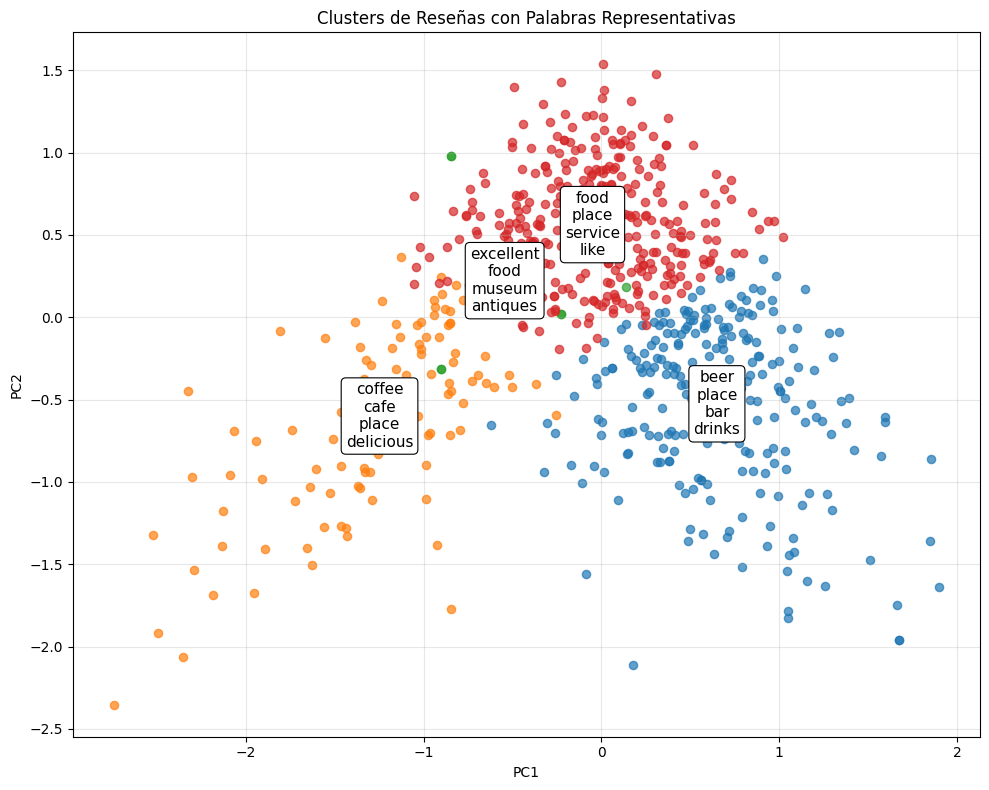

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# PCA
X = np.vstack(data['embedding'])
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
data['pca_x'] = coords[:,0]
data['pca_y'] = coords[:,1]


# Scatter plot
plt.figure(figsize=(10,8))
for c in sorted(data['cluster'].unique()):
    subset = data[data.cluster == c]
    plt.scatter(subset.pca_x, subset.pca_y, s=35, alpha=0.7, label=f"Cluster {c}")

# Add keywords text near centroids
for c in sorted(data['cluster'].unique()):
    subset = data[data.cluster == c]
    cx, cy = subset.pca_x.mean(), subset.pca_y.mean()
    words = representative_words[c][:4]
    plt.text(cx, cy, "\n".join(words), fontsize=11, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.8))

plt.title("Clusters de Reseñas con Palabras Representativas")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
